In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [2]:
def plot_origin(dataset):
    groups=[0,1,2,3,4,5,6,7,8]
    i=1
    plt.figure(figsize=(25, 20))
    for group in groups:
        plt.subplot(len(groups),1,i)
        plt.plot(dataset.values[:,group])
        plt.title(dataset.columns[group],y=0.5,loc='right')
        i+=1
    plt.show()

In [3]:
def plot_result(history,x,y,scaler,range_number=-1):
    predicted_y=model_GRU.predict(x)
    # draw loss
    plt.figure(figsize=(20, 30))
    plt.subplot(411)
    plt.plot(history_GRU.epoch, history_GRU.history['loss'], )
    plt.plot(history_GRU.epoch, history_GRU.history['val_loss'])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title(' Model Loss')
    plt.legend(['Training', 'Test'])
    #longitude
    plt.subplot(412)
    y[:,:-2]=rollback_normalize(y[:,:-2],scaler.data_min_[-3:-2],scaler.data_max_[-3:-2])
    predicted_y[:,:-2]=rollback_normalize(predicted_y[:,:-2],scaler.data_min_[-3:-2],scaler.data_max_[-3:-2])
    plt.plot(y[:range_number,:-2])
    plt.plot(predicted_y[:range_number,:-2])
    plt.xlabel('index')
    plt.ylabel('longitude')
    plt.title('longitude prediction')#'longitude','latitude','altitude'
    plt.legend(['Actual','Predicted'])
    #latitude
    plt.subplot(413)
    y[:,-2:-1]=rollback_normalize(y[:,-2:-1],scaler.data_min_[-2:-1],scaler.data_max_[-2:-1])
    predicted_y[:,-2:-1]=rollback_normalize(predicted_y[:,-2:-1],scaler.data_min_[-2:-1],scaler.data_max_[-2:-1])
    plt.plot(y[:range_number,1:-1])
    plt.plot(predicted_y[:range_number,1:-1])
    plt.xlabel('index')
    plt.ylabel('latitude')
    plt.title('latitude prediction')#'longitude','latitude','altitude'
    plt.legend(['Actual','Predicted'])
    #altitude
    plt.subplot(414)
    y[:,-1:]=rollback_normalize(y[:,-1:],scaler.data_min_[-1:],scaler.data_max_[-1:])
    predicted_y[:,-1:]=rollback_normalize(predicted_y[:,-1:],scaler.data_min_[-1:],scaler.data_max_[-1:])
    plt.plot(y[:range_number,2:])
    plt.plot(predicted_y[:range_number,2:])
    plt.xlabel('index')
    plt.ylabel('latitude')
    plt.title('latitude prediction')#'longitude','latitude','altitude'
    plt.legend(['Actual','Predicted'])
    plt.show()

In [4]:
def create_dataset(data,n_in=1,n_out=1,dropnan=True):
    n_vars=1 if type(data) is list else data.shape[1]
    df=DataFrame(data)
    cols,names =list(),list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names =names+ [('var%d(t-%d)' %(j+1,i)) for j in range(n_vars)]
    
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names=names+[('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names=names+[('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg=concat(cols,axis=1)
    agg.columns=names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
def rollback_normalize(alist,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(alist)):
            alist[i] = alist[i]*delta + low
    return alist

In [6]:
def get_normalized(data):
    data=data.astype('float32')
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(data)
    return scaled_data,scaler

In [7]:
precessed_parent_path=r'C:\\Users\\season\\Desktop\\数据\\preprocess_data_feature\\'
data_filename='58606.txt'
dataset=pd.read_csv(precessed_parent_path+data_filename,header=0,index_col=0)

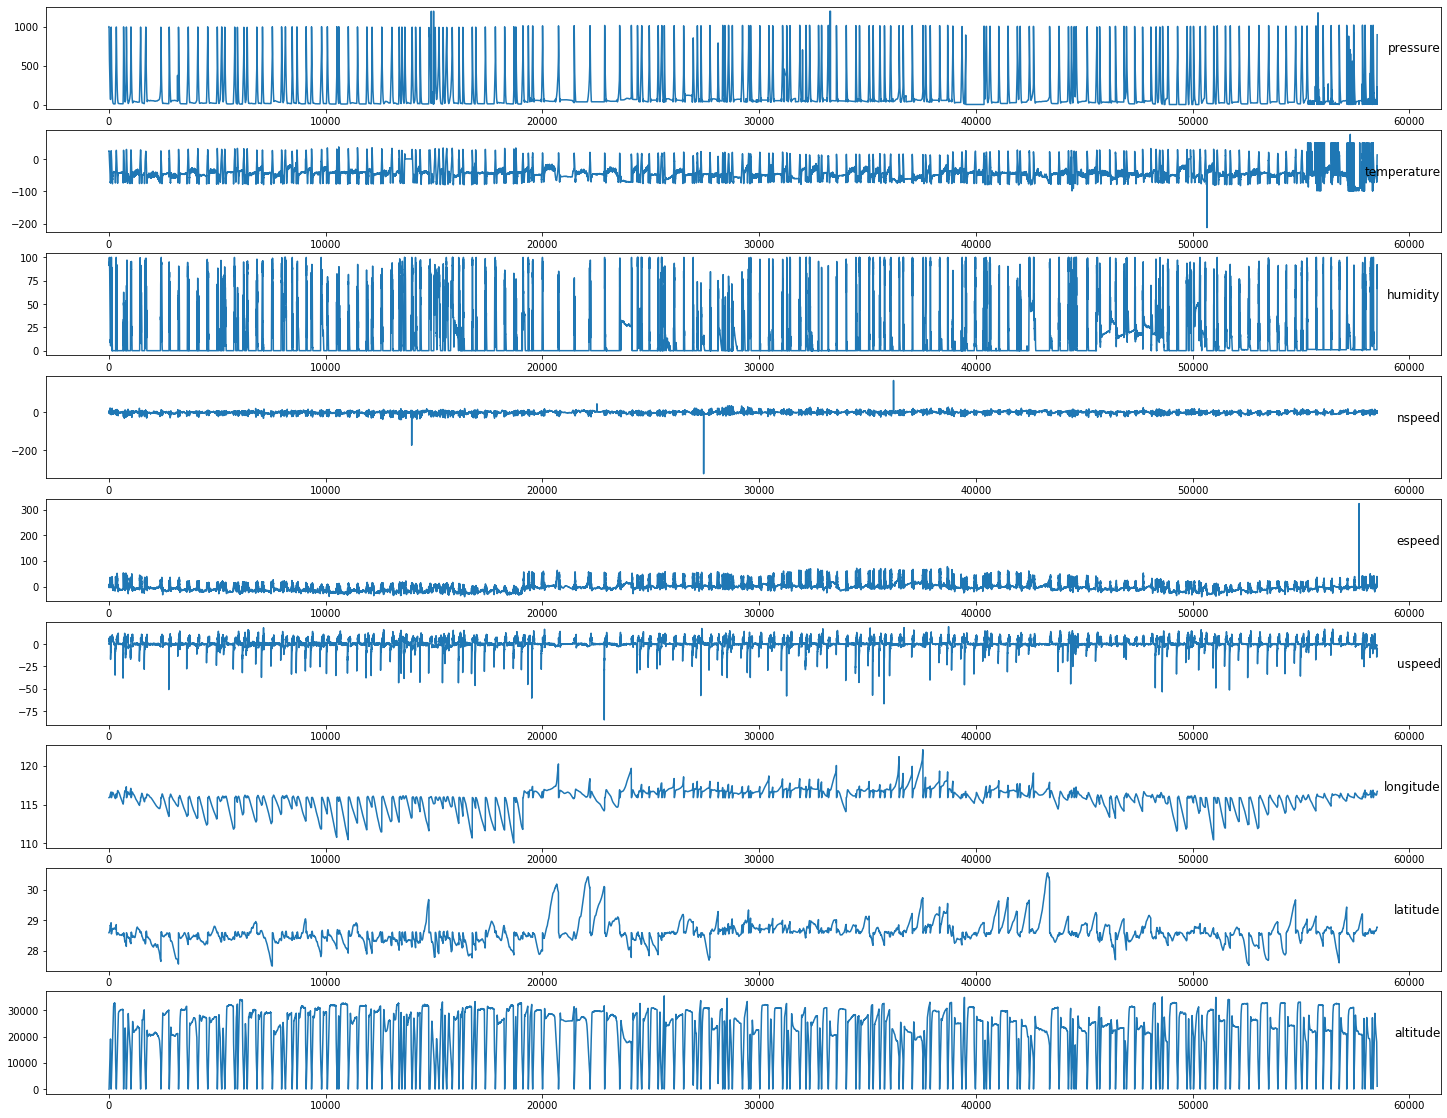

In [8]:
plot_origin(dataset)

In [9]:
values=dataset.values
scaled_data,scaler=get_normalized(values)
reframed=create_dataset(scaled_data,1 ,1)

In [11]:
kf = KFold(n_splits=5)
X,y=reframed.values[:,:-3],reframed.values[:,-3:]
counter=0
historys=[]
test_ys=[]
test_Xs=[]
for trainset_index,testset_index in kf.split(reframed.values):
    train_X,train_y= X[trainset_index], y[trainset_index]
    test_X,test_y= X[testset_index], y[testset_index]
    train_X=train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    test_X=test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
    model_GRU = Sequential()
    model_GRU.add(GRU(50, input_shape=(train_X.shape[1],train_X.shape[2])))
    model_GRU.add(Dense(3))
    model_GRU.compile(loss='mae',optimizer='adam',metrics=['mse','mae'])
    history_GRU=model_GRU.fit(train_X,train_y,epochs=50,batch_size=72,validation_data=(test_X,test_y),verbose=1,shuffle=False)
    historys.append(history_GRU)
    test_ys.append(test_y)
    test_Xs.append(test_X)
    counter=counter+1
    if(counter==1):
        break
    print("################################################################################")

Train on 46812 samples, validate on 11704 samples
Epoch 1/50
46812/46812 [==============================] - 4s 84us/step - loss: 0.0638 - mse: 0.0092 - mae: 0.0638 - val_loss: 0.0381 - val_mse: 0.0030 - val_mae: 0.0381
Epoch 2/50
46812/46812 [==============================] - 2s 53us/step - loss: 0.0331 - mse: 0.0025 - mae: 0.0331 - val_loss: 0.0166 - val_mse: 5.7341e-04 - val_mae: 0.0166
Epoch 3/50
46812/46812 [==============================] - 3s 53us/step - loss: 0.0175 - mse: 7.2817e-04 - mae: 0.0175 - val_loss: 0.0113 - val_mse: 3.1579e-04 - val_mae: 0.0113
Epoch 4/50
46812/46812 [==============================] - 3s 57us/step - loss: 0.0090 - mse: 2.6872e-04 - mae: 0.0090 - val_loss: 0.0053 - val_mse: 1.2389e-04 - val_mae: 0.0053
Epoch 5/50
46812/46812 [==============================] - 3s 54us/step - loss: 0.0080 - mse: 2.3558e-04 - mae: 0.0080 - val_loss: 0.0033 - val_mse: 1.0618e-04 - val_mae: 0.0033
Epoch 6/50
46812/46812 [==============================] - 3s 56us/step - loss

46812/46812 [==============================] - 3s 68us/step - loss: 0.0055 - mse: 1.7255e-04 - mae: 0.0055 - val_loss: 0.0047 - val_mse: 1.1499e-04 - val_mae: 0.0047
Epoch 47/50
46812/46812 [==============================] - 3s 66us/step - loss: 0.0057 - mse: 1.8374e-04 - mae: 0.0057 - val_loss: 0.0032 - val_mse: 1.0197e-04 - val_mae: 0.0032
Epoch 48/50
46812/46812 [==============================] - 3s 64us/step - loss: 0.0053 - mse: 1.6793e-04 - mae: 0.0053 - val_loss: 0.0025 - val_mse: 9.6318e-05 - val_mae: 0.0025
Epoch 49/50
46812/46812 [==============================] - 3s 62us/step - loss: 0.0055 - mse: 1.7385e-04 - mae: 0.0055 - val_loss: 0.0033 - val_mse: 1.0371e-04 - val_mae: 0.0033
Epoch 50/50
46812/46812 [==============================] - 3s 61us/step - loss: 0.0046 - mse: 1.5646e-04 - mae: 0.0046 - val_loss: 0.0032 - val_mse: 1.0028e-04 - val_mae: 0.0032


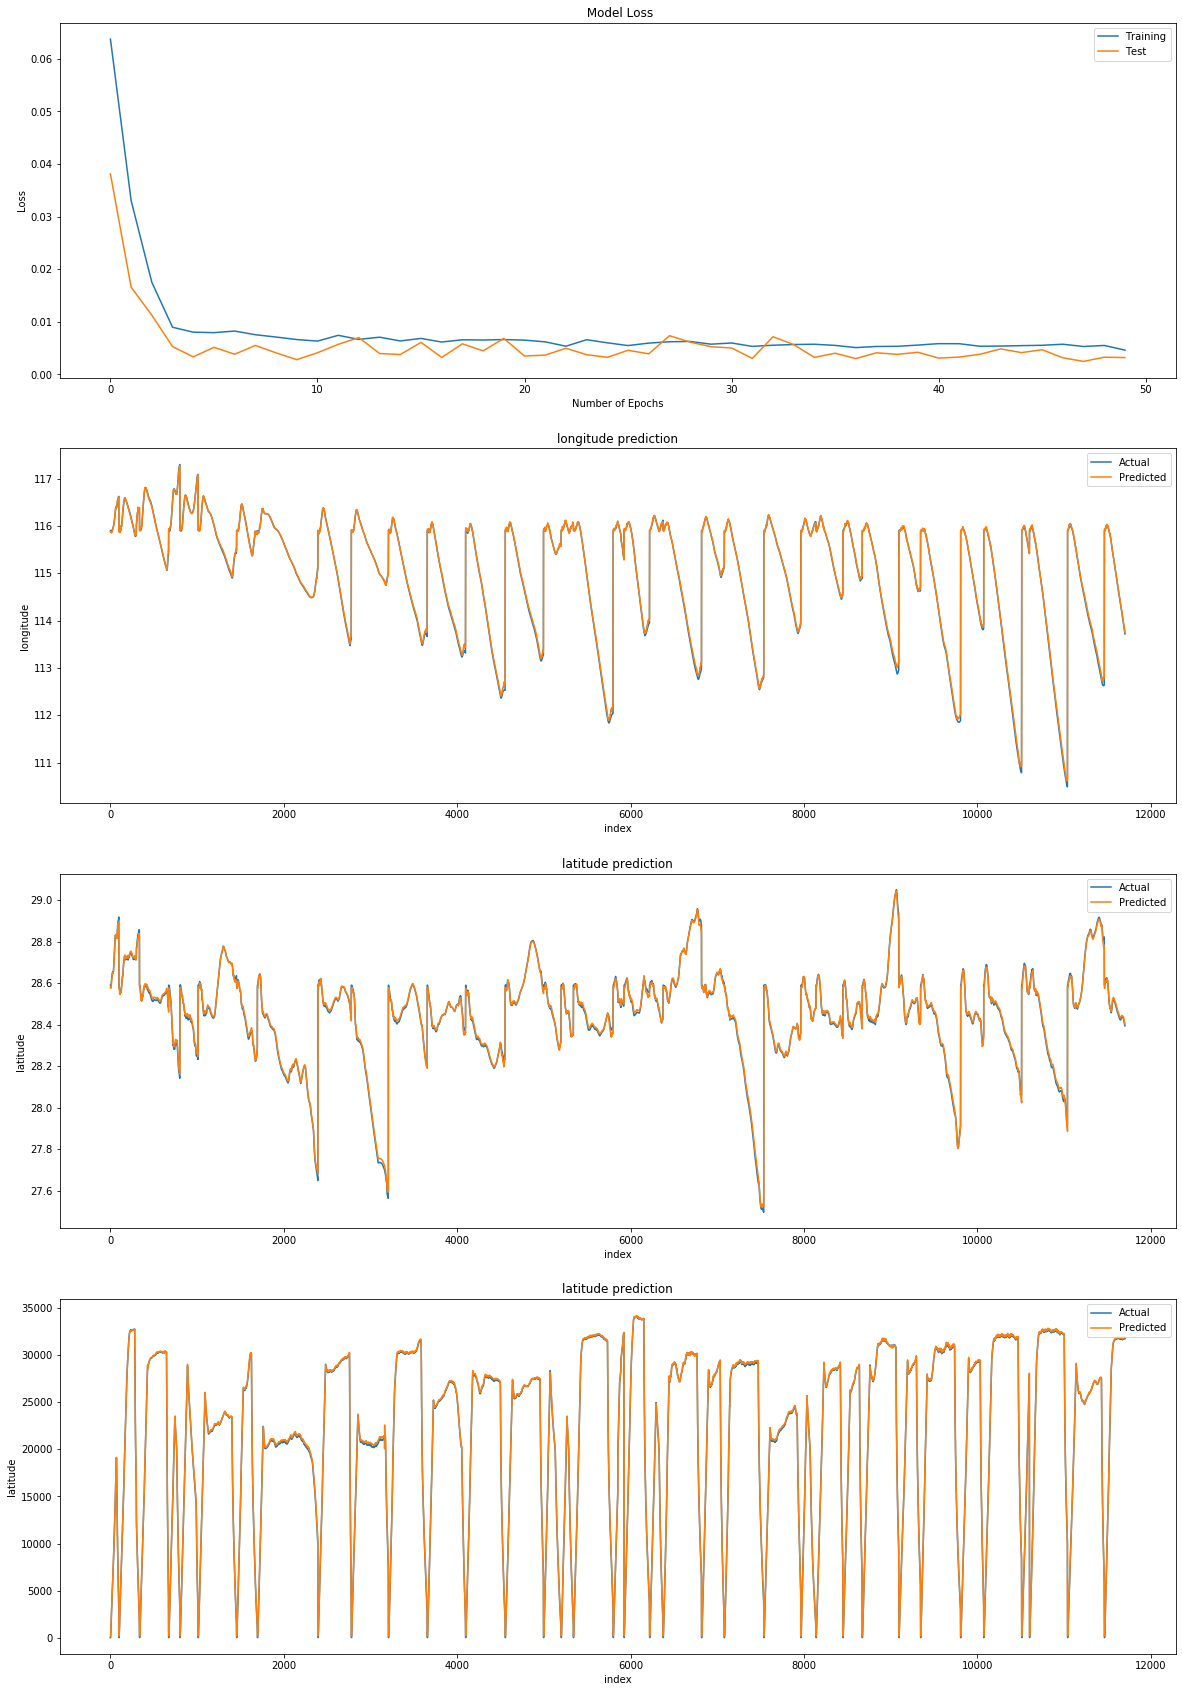

In [12]:
plot_result(historys[0],test_Xs[0],test_ys[0],scaler)